## Feature extraction for hotel reviews using the features from Chapter 5 and the HW training data.

In [150]:
import math, re, csv

In [97]:
import numpy as np

Let's define functions for each of the 6 features introduced in Ch. 6.  

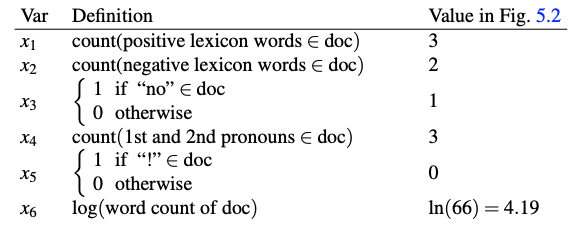

The first two features involve counting the number of positive and negative words in the reviews.  So let's do those them first.  And create a sample review to play with.

In [98]:
with open("positive-words.txt") as pos:
	POSwords = set(pos.read().split())

In [99]:
with open("negative-words.txt") as neg:
	NEGwords = set(neg.read().split())  

In [100]:
example_review = "ID-204 I mistakenly thought that since my multiple stays at other Marriott locations were excellent and clean that this location would be as well. Man was I wrong. This place is terrible. The room was very dirty and there were dead bugs everywhere. The room smelled horrible. I couldn't get the room windows open enough to help remove the smell. It took a while to find this place with all the construction in the area and the awkward road design in the area. I will never stay here again!"

In [101]:
def countsentiment(words, sentimentwordlist):
    return len(words.intersection(sentimentwordlist))

Representing the words in the text and the sentiment word list allows us to use methods like intersection.

In [102]:
countsentiment(set(example_review.split()), POSwords)

3

In [103]:
countsentiment(set(example_review.split()), NEGwords)

6

Let's see the negative words in this review for curiosity.

In [104]:
examplewords = set(example_review.split())

In [105]:
examplewords.intersection(NEGwords)

{'awkward', 'bugs', 'dead', 'dirty', 'mistakenly', 'smelled'}

Next feature is pronoun count.  Here's our list pronouns.

In [106]:
pronouns = {"I", "me", "mine", "my", "you", "your", "yours", "we", "us", "ours"}

In [107]:
def countpronouns(words):
	return len(words.intersection(pronouns))

In [108]:
countpronouns(set(examplewords))

2

Let's check that.

In [109]:
examplewords.intersection(pronouns)

{'I', 'my'}

Does the review contain the word "not"?  If so return 1, otherwise 0.

In [110]:
def containsanot (words):
    if" not" in words: return 1
    else: return 0
    

In [111]:
containsanot(examplewords)

0

Any words ending with an exclamation mark?

In [112]:
def contains_exclamation(words):
    excl = re.compile(r"\!$")
    for word in words:
        if excl.search(word): return 1
    return 0


In [113]:
contains_exclamation(examplewords)

1

And finally the length of the review. 

In [114]:
def review_length(text):
    return math.log(len(text))

In [115]:
review_length(example_review)

6.192362489474872

Now we just need to use these extractors to take a review and return the features in some useful form, which in python often turns out to be a dictionary.  We'll take a review and extract the features as key/value pairs bundled up in a dictionary representing that review. 

In [116]:
def extractfeatures(review):
	""" Review is one big string. Return a dict with the feature values extracted. """

	review_text = review.split()
	review_words = set(review_text)

	return {
			"positivity" : countsentiment(review_words, POSwords),     
			"negativity" :  countsentiment(review_words, NEGwords),
			"containsnot" : containsanot(review_words),
			"containsexclaim" :  contains_exclamation(review_words),
			"pronouns" :  countpronouns(review_words),
			"length" : review_length(review_text)
			}

In [117]:
extractfeatures(example_review)

{'positivity': 3,
 'negativity': 6,
 'containsnot': 0,
 'containsexclaim': 1,
 'pronouns': 2,
 'length': 4.48863636973214}

Let's run extractor  over all the reviews in our positive and negative training files.  As we do this we'll add an additional key ("label") in the dictionary to capture the review class (1 or 0).

In [118]:
with open("hotelPosT-Dev.txt") as posReviews, open("hotelNegT-Dev.txt") as negReviews:
	posExamples = []; negExamples = []

	for review in posReviews:
		reviewfeatures = extractfeatures(review)
		reviewfeatures["label"] = 1
		posExamples.append(reviewfeatures)

	for review in negReviews:
		reviewfeatures = extractfeatures(review)
		reviewfeatures["label"] = 0
		negExamples.append(reviewfeatures)

In [119]:
posExamples

[{'positivity': 5,
  'negativity': 0,
  'containsnot': 0,
  'containsexclaim': 0,
  'pronouns': 1,
  'length': 4.248495242049359,
  'label': 1},
 {'positivity': 2,
  'negativity': 0,
  'containsnot': 0,
  'containsexclaim': 1,
  'pronouns': 1,
  'length': 4.204692619390966,
  'label': 1},
 {'positivity': 4,
  'negativity': 2,
  'containsnot': 0,
  'containsexclaim': 0,
  'pronouns': 3,
  'length': 4.406719247264253,
  'label': 1},
 {'positivity': 5,
  'negativity': 0,
  'containsnot': 0,
  'containsexclaim': 1,
  'pronouns': 1,
  'length': 4.290459441148391,
  'label': 1},
 {'positivity': 6,
  'negativity': 0,
  'containsnot': 0,
  'containsexclaim': 0,
  'pronouns': 1,
  'length': 4.997212273764115,
  'label': 1},
 {'positivity': 6,
  'negativity': 0,
  'containsnot': 0,
  'containsexclaim': 1,
  'pronouns': 2,
  'length': 4.770684624465665,
  'label': 1},
 {'positivity': 2,
  'negativity': 0,
  'containsnot': 0,
  'containsexclaim': 1,
  'pronouns': 0,
  'length': 3.7612001156935624,

Now we need to write this training data out in the appropriate format for use by the logistic regression code. Fortunately, python's csv package provides just what we need in the DictWriter methods.  This provides the means to write dictionary contents out to a csv file in a specified order. 

In [120]:
with open("HotelDev.csv", mode='w') as csvfile:
	fieldnames =["positivity", "negativity", "containsnot", "containsexclaim", "pronouns", "length", "label"]
	writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
	writer.writeheader()
	for review in posExamples+negExamples:
		writer.writerow(review)


To read that back into a numpy array we can use the numpy genfromtxt method.  Putting the training examples in x and the corresponding classes in y.

In [121]:
def loadcsvtrain(filename):
	""" return a training array, and a 1-d array of labels """

	x = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=(0,1,2,3,4,5))
	y = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=(6))

	return x, y

In [122]:
x, y = loadcsvtrain("HotelDev.csv")

That should give us 20 rows (examples) and 6 columns (features) for x.  y should be 20 x 1.

In [123]:
np.shape(x)

(20, 6)

In [157]:
np.shape(y)

(20,)

In [86]:
x

array([[5.        , 0.        , 0.        , 0.        , 1.        ,
        4.24849524],
       [2.        , 0.        , 0.        , 1.        , 1.        ,
        4.20469262],
       [4.        , 2.        , 0.        , 0.        , 3.        ,
        4.40671925],
       [5.        , 0.        , 0.        , 1.        , 1.        ,
        4.29045944],
       [6.        , 0.        , 0.        , 0.        , 1.        ,
        4.99721227],
       [6.        , 0.        , 0.        , 1.        , 2.        ,
        4.77068462],
       [2.        , 0.        , 0.        , 1.        , 0.        ,
        3.76120012],
       [8.        , 0.        , 0.        , 0.        , 4.        ,
        5.03043792],
       [6.        , 0.        , 0.        , 1.        , 4.        ,
        4.95582706],
       [8.        , 0.        , 0.        , 0.        , 1.        ,
        4.70048037],
       [3.        , 6.        , 0.        , 1.        , 2.        ,
        4.48863637],
       [2.        , 6

In [134]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])